<a href="https://colab.research.google.com/github/anomaitech/GSL-basin/blob/main/CLSM_dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-anomaitech')

In [2]:
aoi = ee.FeatureCollection('projects/ee-anomaitech/assets/SALT_LAKE')

In [ ]:
# Load AOI from GEE Asset
aoi = ee.FeatureCollection('projects/ee-anomaitech/assets/SALT_LAKE')

# Load the CLSM dataset
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR")

# Select soil moisture bands
soil_moisture = era5.select(['volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3','volumetric_soil_water_layer_4'])

# Clip the images to AOI
clipped = soil_moisture.map(lambda image: image.clip(aoi))

# Reduce to a single image by averaging over time
monthly_mean = clipped.mean()


In [ ]:
# Define export parameters
task = ee.batch.Export.image.toDrive(
    image=monthly_mean,
    description="SoilMoisture_SaltLake",
    folder="GEE_Exports",
    fileNamePrefix="soil_moisture_salt_lake",
    region=aoi.geometry(),
    scale=25000,  # Adjust resolution
    fileFormat="GeoTIFF",
    maxPixels=1e13
)

# Start the export task
task.start()
print("Exporting to Google Drive... Check GEE Task Manager for progress.")


In [ ]:
# prompt: find area of aoi

# Compute the area of the AOI in square kilometers.
area = aoi.geometry().area().divide(1000 * 1000).getInfo()

print('Area of AOI:', area, 'km^2')

Area of AOI: 93642.93958539197 km^2


In [ ]:
import pandas as pd
coordinates=pd.read_csv('/content/drive/MyDrive/BYU/research/imputation/new_measurements (2).csv')


In [ ]:
lat=coordinates['lat_dec']
lon=coordinates['long_dec']

In [ ]:
points = [ee.Geometry.Point([lon, lat]) for lon, lat in zip(coordinates['long_dec'], coordinates['lat_dec'])]


In [ ]:

# Load the ImageCollection
clsm = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D")

# Select the available soil moisture bands
water_storage = clsm.select([
    'SoilMoist_P_tavg', 'SoilMoist_RZ_tavg', 'SoilMoist_S_tavg'
])

# Assuming you have defined 'coordinates' somewhere in your code
points = [ee.Geometry.Point([lon, lat]) for lon, lat in zip(coordinates['long_dec'], coordinates['lat_dec'])]

# Function to process data for a single year
def process_year(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    # Filter the ImageCollection for the specific year
    filtered_water_storage = water_storage.filterDate(start_date, end_date)

    # Generate a list of monthly intervals for the year
    months = ee.List.sequence(0, 11).map(lambda m: start_date.advance(m, 'month'))

    # Calculate monthly mean water storage
    def monthly_mean_image(date):
        start = ee.Date(date)
        end = start.advance(1, 'month')
        images_in_month = filtered_water_storage.filterDate(start, end)
        return images_in_month.mean().set('month', start.format('YYYY-MM'))

    monthly_mean_images = ee.ImageCollection.fromImages(months.map(monthly_mean_image))

    # Extract mean values for each point
    def extract_mean(image):
        features = []
        for i, point in enumerate(points):
            mean_dict = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=25000,
                maxPixels=1e13
            )
            feature = ee.Feature(None, {
                'month': image.get('month'),
                'point': f'Point-{i + 1}',
                'SoilMoist_P_tavg': mean_dict.get('SoilMoist_P_tavg'),
                'SoilMoist_RZ_tavg': mean_dict.get('SoilMoist_RZ_tavg'),
                'SoilMoist_S_tavg': mean_dict.get('SoilMoist_S_tavg')
            })
            features.append(feature)
        return ee.FeatureCollection(features)

    # Apply extraction for each monthly image
    monthly_mean_values_fc = monthly_mean_images.map(extract_mean).flatten()

    return monthly_mean_values_fc

# Process data year by year
all_data = []
for year in range(2015, 2020):  # Adjust the range as needed
    print(f"Processing year {year}...")
    year_data = process_year(year).getInfo()  # Extract information from Earth Engine
    all_data.extend(year_data['features'])  # Collect all features
    print(f"Completed processing for year {year}")

# Organize data into a Pandas DataFrame
records = []
for feature in all_data:
    props = feature['properties']
    record = {
        'Point': props['point'],
        'Month': props['month'],  # 'YYYY-MM' format
        'SoilMoist_P_tavg': props.get('SoilMoist_P_tavg'),
        'SoilMoist_RZ_tavg': props.get('SoilMoist_RZ_tavg'),
        'SoilMoist_S_tavg': props.get('SoilMoist_S_tavg')
    }
    records.append(record)

# Create a DataFrame
raw_df = pd.DataFrame(records)

# Pivot the DataFrame to create "year-month" columns
pivot_df = raw_df.pivot(index='Point', columns='Month', values=['SoilMoist_P_tavg', 'SoilMoist_RZ_tavg', 'SoilMoist_S_tavg'])
pivot_df.columns = [f"{col[1]}_{col[0]}" for col in pivot_df.columns]  # Combine 'Month' and soil moisture types
pivot_df.reset_index(inplace=True)

# Export the DataFrame to a CSV file
output_file = "/content/drive/MyDrive/BYU/research/imputation/new_measurements_soil_data.csv"
pivot_df.to_csv(output_file, index=False)
print(f"Data exported to {output_file}")



Processing year 2015...
Completed processing for year 2015
Processing year 2016...
Completed processing for year 2016
Processing year 2017...
Completed processing for year 2017
Processing year 2018...
Completed processing for year 2018
Processing year 2019...
Completed processing for year 2019
Data exported to /content/drive/MyDrive/BYU/research/imputation/new_measurements_soil_data.csv


In [ ]:
points

In [ ]:
import geemap
import ee
import pandas as pd
from datetime import datetime

# Initialize Earth Engine
ee.Initialize()

# Load the ImageCollection
clsm = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D")\
          .filter(ee.Filter.date('2004-01-01', '2023-12-31'))

# Select the available soil moisture bands
water_storage = clsm.select([
    'SoilMoist_P_tavg', 'SoilMoist_RZ_tavg', 'SoilMoist_S_tavg'
])

# Define points as a list of ee.Geometry.Point
points = [
    ee.Geometry.Point([-112.553539, 37.113874]),  # Example coordinates
    # Add more points if needed
]

# Define start and end dates
filtered_start_date = '2004-01-01'
filtered_end_date = '2023-12-31'

# Filter the ImageCollection to include only these dates
filtered_water_storage = water_storage.filterDate(filtered_start_date, filtered_end_date)

# Define start and end dates as ee.Date
start_date = ee.Date(filtered_start_date)
end_date = ee.Date(filtered_end_date)

# Generate a list of monthly intervals
def get_month_list(start_date, end_date):
    difference = end_date.difference(start_date, 'month').round()
    months = ee.List.sequence(0, difference.subtract(1)).map(
        lambda m: start_date.advance(m, 'month')
    )
    return months

months = get_month_list(start_date, end_date)

# Calculate monthly mean water storage
def monthly_mean_image(date):
    start = ee.Date(date)
    end = start.advance(1, 'month')
    images_in_month = filtered_water_storage.filterDate(start, end)
    return images_in_month.mean().set('month', start.format('YYYY-MM'))

monthly_mean_images = ee.ImageCollection.fromImages(months.map(monthly_mean_image))

# Extract mean values for each point
def extract_mean(image):
    features = []
    for i, point in enumerate(points):
        mean_dict = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=25000,
            maxPixels=1e13
        )
        feature = ee.Feature(None, {
            'month': image.get('month'),
            'point': f'Point-{i + 1}',
            'SoilMoist_P_tavg': mean_dict.get('SoilMoist_P_tavg'),
            'SoilMoist_RZ_tavg': mean_dict.get('SoilMoist_RZ_tavg'),
            'SoilMoist_S_tavg': mean_dict.get('SoilMoist_S_tavg')
        })
        features.append(feature)
    return ee.FeatureCollection(features)

# Apply extraction for each monthly image
monthly_mean_values_fc = monthly_mean_images.map(extract_mean).flatten()

# Convert to Python lists
data = monthly_mean_values_fc.getInfo()

# Organize data into a Pandas DataFrame
records = []
for feature in data['features']:
    props = feature['properties']
    point = props['point']
    month = datetime.strptime(props['month'], '%Y-%m')
    record = {
        'Point': point,
        'Month': month,
        'SoilMoist_P_tavg': props.get('SoilMoist_P_tavg'),
        'SoilMoist_RZ_tavg': props.get('SoilMoist_RZ_tavg'),
        'SoilMoist_S_tavg': props.get('SoilMoist_S_tavg')
    }
    records.append(record)

# Create a DataFrame
df = pd.DataFrame(records)

# Export the DataFrame to a CSV file
output_file = "soil_moisture_data.csv"
df.to_csv(output_file, index=False)
print(f"Data exported to {output_file}")


Data exported to soil_moisture_data.csv


In [ ]:


# Define a function to clip each image in the collection
def clip_image(image):
    return image.clip(aoi)

# Apply the clip function to each image in the collection using map
clsm_tws = clsm.select('TWS_tavg').map(clip_image)
clsm_gws = clsm.select('GWS_tavg').map(clip_image)

In [ ]:
import geemap
import plotly.graph_objects as go
from datetime import datetime
import ee
import numpy as np



# Load the ImageCollection
clsm = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D")\
          .filter(ee.Filter.date('2003-02-01', '2024-09-02'))

# Select both GWS_tavg and TWS_tavg
water_storage = clsm.select(['GWS_tavg', 'TWS_tavg','Evap_tavg','CanopInt_tavg'])

# Load your AOI shapefile as a FeatureCollection
aoi = ee.FeatureCollection('projects/ee-anomaitech/assets/volta_basin')

# Clip the ImageCollection to your AOI
clipped_water_storage = water_storage.map(lambda image: image.clip(aoi))

# Define the start and end dates for the years you want to filter
filtered_start_date = '2003-02-01'
filtered_end_date = '2024-05-01'

# Filter the ImageCollection to include only these years
filtered_water_storage = clipped_water_storage.filterDate(filtered_start_date, filtered_end_date)

# Define start and end dates as ee.Date
start_date = ee.Date(filtered_start_date)
end_date = ee.Date(filtered_end_date)

# Function to generate a list of monthly intervals between start and end dates
def get_month_list(start_date, end_date):
    difference = end_date.difference(start_date, 'month').round()
    months = ee.List.sequence(0, difference.subtract(1)).map(
        lambda m: start_date.advance(m, 'month')
    )
    return months

# Generate the list of months for the filtered years
months = get_month_list(start_date, end_date)

# Function to calculate the monthly mean water storage
def monthly_mean_image(date):
    start = ee.Date(date)
    end = start.advance(1, 'month')
    images_in_month = filtered_water_storage.filterDate(start, end)
    # Compute the mean image for the month
    monthly_mean = images_in_month.mean().set('month', start.format('YYYY-MM'))
    return monthly_mean

# Apply the function over the list of months to get monthly mean images
monthly_mean_images = ee.ImageCollection.fromImages(months.map(monthly_mean_image))

# Function to extract the mean water storage over the AOI
def extract_mean(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=25000,
        maxPixels=1e13
    )
    gws_tavg = mean_dict.get('GWS_tavg')
    tws_tavg = mean_dict.get('TWS_tavg')
    evap_tavg = mean_dict.get('Evap_tavg')
    canopint_tavg = mean_dict.get('CanopInt_tavg')
    return ee.Feature(None, {'month': image.get('month'), 'GWS_tavg': gws_tavg, 'TWS_tavg': tws_tavg,'Evap_tavg':evap_tavg,'CanopInt_tavg':canopint_tavg})

# Apply the extraction function over the monthly mean images
monthly_mean_values_fc = monthly_mean_images.map(extract_mean)

# Retrieve the months and mean values
months_list = monthly_mean_values_fc.aggregate_array('month').getInfo()
gws_tavg_list = monthly_mean_values_fc.aggregate_array('GWS_tavg').getInfo()
tws_tavg_list = monthly_mean_values_fc.aggregate_array('TWS_tavg').getInfo()
evap_tavg_list = monthly_mean_values_fc.aggregate_array('Evap_tavg').getInfo()
canopint_tavg_list = monthly_mean_values_fc.aggregate_array('CanopInt_tavg').getInfo()
# Convert month strings to datetime objects and handle None values
gws_tavg_list = [float(value) if value is not None else None for value in gws_tavg_list]
tws_tavg_list = [float(value) if value is not None else None for value in tws_tavg_list]
evap_tavg_list = [float(value) if value is not None else None for value in evap_tavg_list]
canopint_tavg_list = [float(value) if value is not None else None for value in canopint_tavg_list]
months_datetime = [datetime.strptime(month, '%Y-%m') for month in months_list]

# Calculate reference averages (2004-2009)
ref_start = datetime(2004, 1, 1)
ref_end = datetime(2009, 12, 31)
ref_gws = [v for d, v in zip(months_datetime, gws_tavg_list) if ref_start <= d <= ref_end and v is not None]
ref_tws = [v for d, v in zip(months_datetime, tws_tavg_list) if ref_start <= d <= ref_end and v is not None]
ref_evap = [v for d, v in zip(months_datetime, evap_tavg_list) if ref_start <= d <= ref_end and v is not None]


gws_ref_avg = np.mean(ref_gws)
tws_ref_avg = np.mean(ref_tws)
evap_ref_avg = np.mean(ref_evap)


# Calculate anomalies
gws_anomalies = [v  if v is not None else None for v in gws_tavg_list]
tws_anomalies = [v  if v is not None else None for v in tws_tavg_list]
evap_anomalies = [v  if v is not None else None for v in evap_tavg_list]

# Filter out None values for plotting
filtered_data_gws = [(date, value) for date, value in zip(months_datetime, gws_anomalies) if value is not None]
filtered_data_tws = [(date, value) for date, value in zip(months_datetime, tws_anomalies) if value is not None]
filtered_data_evap = [(date, value/10) for date, value in zip(months_datetime, evap_anomalies) if value is not None]



dates_gws, values_gws = zip(*filtered_data_gws)
dates_tws, values_tws = zip(*filtered_data_tws)
dates_evap, values_evap = zip(*filtered_data_evap)

# Create the Plotly plot
fig = go.Figure()

# Add GWS_tavg anomaly trace
fig.add_trace(go.Scatter(x=dates_gws, y=values_gws, mode='lines+markers', name='GWS_tavg Anomaly'))

# Add TWS_tavg anomaly trace
# fig.add_trace(go.Scatter(x=dates_tws, y=values_tws, mode='lines+markers', name='TWS_tavg Anomaly'))
# fig.add_trace(go.Scatter(x=dates_evap, y=values_evap*3600*24, mode='lines+markers', name='Evap_tavg Anomaly'))

fig.update_layout(
    title='Monthly Water Storage Anomalies (Reference: 2004-2009 Average)',
    xaxis_title='Date',
    yaxis_title='Water Storage Anomaly (mm)',
    legend_title='Variable'
)

# Add a horizontal line at y=0 to represent the reference level
fig.add_shape(
    type="line",
    x0=min(dates_gws + dates_tws),
    y0=0,
    x1=max(dates_gws + dates_tws),
    y1=0,
    line=dict(color="black", width=1, dash="dash"),
)

fig.show()

In [ ]:
gws_ref_avg

1067.4028106242342

In [ ]:
!pip install -U geemap


In [3]:
import ee
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd


startDate = ee.Date('2003-01-01')
endDate = ee.Date('2024-01-01')
timeDifference = endDate.difference(startDate, 'month').round()

# Load the Global Land Data Assimilation System (GLDAS) dataset groundwater storage data
groundwaterData = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D") \
    .select('GWS_tavg') \
    .filterDate(startDate, endDate)

# Generate a list of dates for each month during the time period
dateList = ee.List.sequence(0, ee.Number(timeDifference).subtract(1), 1).map(
    lambda delta: ee.Date(startDate).advance(delta, 'month')
)

# Function to get time series data for the study area
def get_groundwater_series():
    time_series = []
    for month in range(dateList.size().getInfo()):  # Use the size of the ee.List to iterate
        start = ee.Date(dateList.get(month))
        end = start.advance(1, 'month')
        monthlyAvg = groundwaterData.filterDate(start, end).mean().reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=27000
        )
        # Check if 'GWS_tavg' is in the dictionary before accessing it
        if 'GWS_tavg' in monthlyAvg.getInfo():
            time_series.append(monthlyAvg.get('GWS_tavg').getInfo())
        else:
            # Handle the case where 'GWS_tavg' is not found (e.g., append None)
            time_series.append(None)
    return time_series

# Get the groundwater time series data for the study area
time_series_data = get_groundwater_series()

# Convert Earth Engine List to Python list for dates
dates = [ee.Date(dateList.get(i)).format('YYYY-MM').getInfo() for i in range(dateList.size().getInfo())]

# Create a DataFrame for the time series data
df = pd.DataFrame({
    'Date': dates,
    'Mean Groundwater Storage (GWS_tavg)': time_series_data
})

# Plot the time series chart using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Date'],
    y=df['Mean Groundwater Storage (GWS_tavg)'],
    mode='lines',
    name='Mean Groundwater Storage',
    line=dict(color='green')
))

fig.update_layout(
    title='Mean Groundwater Data for Study Area',
    xaxis_title='Time (Months)',
    yaxis_title='Mean Groundwater Storage (GWS_tavg)',
    template='plotly_dark'
)

fig.show()

# Visualize the study

In [4]:
import pandas as pd
grace_data=pd.read_csv('/content/drive/MyDrive/BYU/research/saltlake/Grace TWSa vs GWSa.csv')

In [5]:
grace_data['Date'] = pd.to_datetime(grace_data['Date'])

In [10]:
grace_data.head()

,Date,TWSa,Unnamed: 2,Unnamed: 3,GWSa Imputed
0,2002-04-01,4.493000,NaN,NaN,3.36
1,2002-05-01,3.362000,NaN,NaN,4.11
2,2002-06-01,3.517027,NaN,NaN,0.29
3,2002-07-01,-4.827060,NaN,NaN,-0.36
4,2002-08-01,-9.570000,NaN,NaN,-0.19


In [6]:
import geemap
import plotly.graph_objects as go
from datetime import datetime
import ee
import numpy as np


# Load the ImageCollection
clsm = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D")\
          .filter(ee.Filter.date('2003-02-01', '2024-09-02'))

# Select both GWS_tavg and TWS_tavg
water_storage = clsm.select(['GWS_tavg', 'TWS_tavg'])

# Load your AOI shapefile as a FeatureCollection
aoi = ee.FeatureCollection('projects/ee-anomaitech/assets/SALT_LAKE')

# Clip the ImageCollection to your AOI
clipped_water_storage = water_storage.map(lambda image: image.clip(aoi))

# Define the start and end dates for the years you want to filter
filtered_start_date = '2003-03-01'
filtered_end_date = '2024-05-01'

# Filter the ImageCollection to include only these years
filtered_water_storage = clipped_water_storage.filterDate(filtered_start_date, filtered_end_date)

# Define start and end dates as ee.Date
start_date = ee.Date(filtered_start_date)
end_date = ee.Date(filtered_end_date)

# Function to generate a list of monthly intervals between start and end dates
def get_month_list(start_date, end_date):
    difference = end_date.difference(start_date, 'month').round()
    months = ee.List.sequence(0, difference.subtract(1)).map(
        lambda m: start_date.advance(m, 'month')
    )
    return months

# Generate the list of months for the filtered years
months = get_month_list(start_date, end_date)

# Function to calculate the monthly mean water storage
def monthly_mean_image(date):
    start = ee.Date(date)
    end = start.advance(1, 'month')
    images_in_month = filtered_water_storage.filterDate(start, end)
    # Compute the mean image for the month
    monthly_mean = images_in_month.mean().set('month', start.format('YYYY-MM'))
    return monthly_mean

# Apply the function over the list of months to get monthly mean images
monthly_mean_images = ee.ImageCollection.fromImages(months.map(monthly_mean_image))

# Function to extract the mean water storage over the AOI
def extract_mean(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=25000,
        maxPixels=1e13
    )
    gws_tavg = mean_dict.get('GWS_tavg')
    tws_tavg = mean_dict.get('TWS_tavg')
    return ee.Feature(None, {'month': image.get('month'), 'GWS_tavg': gws_tavg, 'TWS_tavg': tws_tavg})

# Apply the extraction function over the monthly mean images
monthly_mean_values_fc = monthly_mean_images.map(extract_mean)

# Retrieve the months and mean values
months_list = monthly_mean_values_fc.aggregate_array('month').getInfo()
gws_tavg_list = monthly_mean_values_fc.aggregate_array('GWS_tavg').getInfo()
tws_tavg_list = monthly_mean_values_fc.aggregate_array('TWS_tavg').getInfo()

# Convert month strings to datetime objects and handle None values
gws_tavg_list = [float(value) if value is not None else None for value in gws_tavg_list]
tws_tavg_list = [float(value) if value is not None else None for value in tws_tavg_list]
months_datetime = [datetime.strptime(month, '%Y-%m') for month in months_list]

ref_start = datetime(2003, 1, 1)
ref_end = datetime(2015, 12, 31)
ref_gws = [v for d, v in zip(months_datetime, gws_tavg_list) if ref_start <= d <= ref_end and v is not None]
ref_tws = [v for d, v in zip(months_datetime, tws_tavg_list) if ref_start <= d <= ref_end and v is not None]

gws_ref_avg = np.mean(ref_gws)
tws_ref_avg = np.mean(ref_tws)

# Filter out None values for plotting
filtered_data_gws = [(date, (value-gws_ref_avg)/10) for date, value in zip(months_datetime, gws_tavg_list) if value is not None]
filtered_data_tws = [(date, (value-tws_ref_avg)/10) for date, value in zip(months_datetime, tws_tavg_list) if value is not None]

dates_gws, values_gws = zip(*filtered_data_gws)
dates_tws, values_tws = zip(*filtered_data_tws)

# Create the Plotly plot


In [8]:
import geemap
import plotly.graph_objects as go
from datetime import datetime
import ee
import numpy as np


# Load the ImageCollection
clsm = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D")\
          .filter(ee.Filter.date('2003-02-01', '2024-09-02'))

# Select both GWS_tavg and TWS_tavg
water_storage = clsm.select(['GWS_tavg', 'TWS_tavg'])

# Load your AOI shapefile as a FeatureCollection
aoi = ee.FeatureCollection('projects/ee-anomaitech/assets/filtered_GSLB')

# Clip the ImageCollection to your AOI
clipped_water_storage = water_storage.map(lambda image: image.clip(aoi))

# Define the start and end dates for the years you want to filter
filtered_start_date = '2003-03-01'
filtered_end_date = '2024-05-01'

# Filter the ImageCollection to include only these years
filtered_water_storage = clipped_water_storage.filterDate(filtered_start_date, filtered_end_date)

# Define start and end dates as ee.Date
start_date = ee.Date(filtered_start_date)
end_date = ee.Date(filtered_end_date)

# Function to generate a list of monthly intervals between start and end dates
def get_month_list(start_date, end_date):
    difference = end_date.difference(start_date, 'month').round()
    months = ee.List.sequence(0, difference.subtract(1)).map(
        lambda m: start_date.advance(m, 'month')
    )
    return months

# Generate the list of months for the filtered years
months = get_month_list(start_date, end_date)

# Function to calculate the monthly mean water storage
def monthly_mean_image(date):
    start = ee.Date(date)
    end = start.advance(1, 'month')
    images_in_month = filtered_water_storage.filterDate(start, end)
    # Compute the mean image for the month
    monthly_mean = images_in_month.mean().set('month', start.format('YYYY-MM'))
    return monthly_mean

# Apply the function over the list of months to get monthly mean images
monthly_mean_images = ee.ImageCollection.fromImages(months.map(monthly_mean_image))

# Function to extract the mean water storage over the AOI
def extract_mean(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=50000,
        maxPixels=1e13
    )
    gws_tavg = mean_dict.get('GWS_tavg')
    tws_tavg = mean_dict.get('TWS_tavg')
    return ee.Feature(None, {'month': image.get('month'), 'GWS_tavg': gws_tavg, 'TWS_tavg': tws_tavg})

# Apply the extraction function over the monthly mean images
monthly_mean_values_fc = monthly_mean_images.map(extract_mean)

# Retrieve the months and mean values in smaller batches
months_list = []
gws_tavg_list = []
tws_tavg_list = []

# Set the batch size (e.g., 50 months at a time)
batch_size = 50

for i in range(0, monthly_mean_values_fc.size().getInfo(), batch_size):
    batch = monthly_mean_values_fc.toList(batch_size, i)
    months_list.extend(batch.map(lambda feature: ee.Feature(feature).get('month')).getInfo())
    gws_tavg_list.extend(batch.map(lambda feature: ee.Feature(feature).get('GWS_tavg')).getInfo())
    tws_tavg_list.extend(batch.map(lambda feature: ee.Feature(feature).get('TWS_tavg')).getInfo())

# Convert month strings to datetime objects and handle None values
gws_tavg_list = [float(value) if value is not None else None for value in gws_tavg_list]
tws_tavg_list = [float(value) if value is not None else None for value in tws_tavg_list]
months_datetime = [datetime.strptime(month, '%Y-%m') for month in months_list]

ref_start = datetime(2003, 1, 1)
ref_end = datetime(2015, 12, 31)
ref_gws = [v for d, v in zip(months_datetime, gws_tavg_list) if ref_start <= d <= ref_end and v is not None]
ref_tws = [v for d, v in zip(months_datetime, tws_tavg_list) if ref_start <= d <= ref_end and v is not None]

gws_ref_avg = np.mean(ref_gws)
tws_ref_avg = np.mean(ref_tws)

# Filter out None values for plotting
filtered_data_gws_filtered = [(date, (value-gws_ref_avg)/10) for date, value in zip(months_datetime, gws_tavg_list) if value is not None]
filtered_data_tws_filtered = [(date, (value-tws_ref_avg)/10) for date, value in zip(months_datetime, tws_tavg_list) if value is not None]



EEException: User memory limit exceeded.

In [7]:
dates_gws, values_gws_filted = zip(*filtered_data_gws_filtered)


NameError: name 'filtered_data_gws_filtered' is not defined

In [7]:
fig = go.Figure()

# Add GWS_tavg trace
# fig.add_trace(go.Scatter(x=dates_gws, y=values_gws, mode='lines+markers', name='GWS_tavg_gldas2.2'))

# Add TWS_tavg trace
fig.add_trace(go.Scatter(x=dates_tws, y=values_tws, mode='lines+markers', name='TWS_tavg_gldas2.2'))
# fig.add_trace(go.Scatter(x=grace_data['Date'], y=grace_data['GWSa Imputed'], mode='lines+markers', name='Grace GWSa'))
fig.add_trace(go.Scatter(x=grace_data['Date'], y=grace_data['TWSa'], mode='lines+markers', name='Grace TWSa'))
fig.update_layout(
    title='Monthly Mean Ground Water Storage and Total Water Storage ({} to {})'.format(filtered_start_date[:4], filtered_end_date[:4]),
    xaxis_title='Date',
    yaxis_title='Water Storage (cm)',
    legend_title='Variable'
)

fig.show()

In [8]:
fig = go.Figure()

# Add GWS_tavg trace
fig.add_trace(go.Scatter(x=dates_gws, y=values_gws, mode='lines+markers', name='GWS_tavg_gldas2.2'))

# Add TWS_tavg trace
# fig.add_trace(go.Scatter(x=dates_tws, y=values_tws, mode='lines+markers', name='TWS_tavg_gldas2.2'))
fig.add_trace(go.Scatter(x=grace_data['Date'], y=grace_data['GWSa Imputed'], mode='lines+markers', name='Grace GWSa'))
# fig.add_trace(go.Scatter(x=grace_data['Date'], y=grace_data['TWSa'], mode='lines+markers', name='Grace TWSa'))
fig.update_layout(
    title='Monthly Mean Ground Water Storage and Total Water Storage ({} to {})'.format(filtered_start_date[:4], filtered_end_date[:4]),
    xaxis_title='Date',
    yaxis_title='Water Storage (cm)',
    legend_title='Variable'
)

fig.show()

In [5]:
fig = go.Figure()

# Add GWS_tavg trace
# fig.add_trace(go.Scatter(x=dates_gws, y=values_gws, mode='lines+markers', name='GWS_tavg_gldas2.2'))
fig.add_trace(go.Scatter(x=dates_gws, y=values_gws_filted, mode='lines+markers', name='GWS_tavg_gldas2.2'))
# Add TWS_tavg trace
# fig.add_trace(go.Scatter(x=dates_tws, y=values_tws, mode='lines+markers', name='TWS_tavg_gldas2.2'))
# fig.add_trace(go.Scatter(x=grace_data['Date'], y=grace_data['GWSa Imputed'], mode='lines+markers', name='Grace GWSa'))
# fig.add_trace(go.Scatter(x=grace_data['Date'], y=grace_data['TWSa'], mode='lines+markers', name='Grace TWSa'))
fig.update_layout(
    title='Monthly Mean Ground Water Storage and Total Water Storage ({} to {})'.format(filtered_start_date[:4], filtered_end_date[:4]),
    xaxis_title='Date',
    yaxis_title='Water Storage (cm)',
    legend_title='Variable'
)

fig.show()

NameError: name 'dates_gws' is not defined

In [ ]:
gws_df=pd.DataFrame(filtered_data_gws)

In [ ]:
gws_df['Date'] = pd.to_datetime(gws_df[0])
gws_df['GWSa']=gws_df[1]

In [ ]:
gws_df.index=gws_df['Date']

In [ ]:

annual_average=gws_df['GWSa'].resample('Y').mean()


<ipython-input-14-7a0f65ba726d>:1: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



In [ ]:
gws_df[gws_df.index.year==2003]['GWSa'].mean()

np.float64(-3.6136548245413076)

In [ ]:
annual_average.values

NameError: name 'annual_average' is not defined

In [ ]:
annual_average_gws=values_gws.re

In [ ]:
anomaly2003_2015=values_gws

In [ ]:
anomaly2004_2009=values_gws

In [ ]:
# Create the Plotly plot
fig = go.Figure()

# Add GWS_tavg trace
fig.add_trace(go.Scatter(x=dates_gws, y=anomaly2004_2009, mode='lines+markers', name='TWS_tavg_2004_2009_anomaly'))

# Add TWS_tavg trace
fig.add_trace(go.Scatter(x=dates_tws, y=anomaly2003_2015, mode='lines+markers', name='TWS_tavg_2003_20015_anomaly'))

fig.update_layout(
    title='Monthly Mean Ground Water Storage with different anomaly period({} to {})'.format(filtered_start_date[:4], filtered_end_date[:4]),
    xaxis_title='Date',
    yaxis_title='Water Storage (cm)',
    legend_title='Variable'
)

fig.show()

In [ ]:
# prompt: dates_gws, values_gws export it to csv

import csv

# Assuming dates_gws and values_gws are already defined in your code
with open('gws_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Date', 'GWS_tavg'])  # Write header row
    for date, value in zip(dates_gws, values_gws):
        writer.writerow([date.strftime('%Y-%m-%d'), value])

print("Data exported to gws_data.csv")

Data exported to gws_data.csv


In [ ]:
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.2 MB/s eta 0:00:00


In [ ]:
import xarray as xr
import geopandas as gpd
import rioxarray  # Allows `xarray` to work with spatial data
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
from shapely.geometry import mapping

# Load NetCDF file (update with your actual file path)
file_path = '/content/drive/MyDrive/BYU/research/TWS_tavg/GLDAS_CLSM025_DA1_D_2003_GWS_tavg_monthly.nc'
ds = xr.open_dataset(file_path)

# Load your AOI shapefile
aoi = gpd.read_file('/content/drive/MyDrive/BYU/research/gldas2_2/volta/VoltaBasin.zip')

# Ensure AOI and NetCDF data use the same coordinate reference system
if not ds.rio.crs:
    # Set the CRS explicitly if it's not already set
    ds = ds.rio.write_crs("EPSG:4326")  # Adjust to match the dataset's CRS if different

# Align the AOI CRS with the dataset's CRS
aoi = aoi.to_crs(ds.rio.crs)

# Clip the NetCDF data to the AOI
ds_clipped = ds.rio.clip(aoi.geometry.apply(mapping), ds.rio.crs)

# Filter data for the desired date range and calculate monthly mean
ds_filtered = ds_clipped.sel(time=slice('2003-03-01', '2024-05-01'))
monthly_mean = ds_filtered.resample(time='M').mean()

# Calculate reference period averages (e.g., 2004-01-01 to 2009-12-31)
ref_period = monthly_mean.sel(time=slice('2004-01-01', '2009-12-31'))
gws_ref_avg = ref_period['GWS_tavg'].mean().item()

# Calculate anomalies by subtracting the reference mean and scaling
gws_anomaly = (monthly_mean['GWS_tavg'] - gws_ref_avg) / 10

# Prepare data for plotting
# Convert the 'time' DataArray directly to pandas
dates = monthly_mean['time'].to_pandas()
gws_values = gws_anomaly.values

# Create the Plotly plot
fig = go.Figure()

# Add GWS_tavg trace
fig.add_trace(go.Scatter(x=dates, y=gws_values, mode='lines+markers', name='GWS_tavg'))

# Customize layout
fig.update_layout(
    title='Monthly Mean Ground Water Storage Anomaly (2003 to 2024)',
    xaxis_title='Date',
    yaxis_title='Water Storage Anomaly (cm)',
    legend_title='Variable'
)

fig.show()

In [ ]:
gws_values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [ ]:
import ee
import xarray as xr
import rioxarray
import netCDF4 as nc
import os
import math

# ... (your authentication and initialization code) ...

clsm = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G0nc25/DA1D").filter(ee.Filter.date('2003-02-01', '2024-05-31')).select('TWS_tavg')

# Function to process a tile of the globe
def process_tile(tile_id, start_date, end_date):
    # Define tile boundaries (example: divide the globe into 4 tiles)
    tile_width = 180  # Longitude width of a tile
    tile_height = 90   # Latitude height of a tile
    lon_start = -180 + (tile_id % 2) * tile_width
    lat_start = 90 - (tile_id // 2) * tile_height

    tile_geometry = ee.Geometry.Rectangle([lon_start, lat_start, lon_start + tile_width, lat_start - tile_height])

    subset = clsm.filter(ee.Filter.date(start_date, end_date)).filterBounds(tile_geometry)
    subset_image = subset.toBands()

    export_params_geotiff = {
        'image': subset_image,
        'description': f'CLSM_TWS_tavg_geotiff_tile{tile_id}_{start_date}_{end_date}',
        'folder': '/content/drive/MyDrive/BYU/research/TWS_tavg',
        'fileNamePrefix': f'CLSM_TWS_tavg_tile{tile_id}_{start_date}_{end_date}',
        'region': tile_geometry,
        'scale': 25000,
        'crs': 'EPSG:4326',
        'fileFormat': 'GeoTIFF',
        'maxPixels': 1e13, #increased for global datasets
    }

    task_geotiff = ee.batch.Export.image.toDrive(**export_params_geotiff)
    task_geotiff.start()


# Define the time range and chunk size (in years)
start_year = 2003
end_year = 2024
chunk_size = 1

# Number of tiles (example: 4 tiles for the globe)
num_tiles = 4

# Loop through the time range and tiles
for year in range(start_year, end_year + 1, chunk_size):
    start_date = f'{year}-01-01'
    end_date = f'{year + chunk_size - 1}-12-31'
    for tile_id in range(num_tiles):
        process_tile(tile_id, start_date, end_date)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install xarray rioxarray netcdf4 dask

In [ ]:


import os
import xarray as xr
import glob

def merge_geotiffs_to_netcdf(folder_path, output_file):
  """Merges GeoTIFF files in a folder into a single NetCDF file.
  Args:
    folder_path: Path to the folder containing GeoTIFF files.
    output_file: Path to the output NetCDF file.
  """
  geotiff_files = glob.glob(os.path.join(folder_path, '*.tif'))
  # Open each GeoTIFF file as an xarray dataset
  datasets = []
  for file in geotiff_files:
    try:
      ds = xr.open_dataset(file, engine="rasterio")
      datasets.append(ds)
    except Exception as e:
      print(f"Error opening {file}: {e}")
      continue

  if not datasets:
    print("No GeoTIFF files found or could be opened.")
    return

  # Merge the datasets along the time dimension
  merged_dataset = xr.concat(datasets, dim='time')
  # Save the merged dataset to a NetCDF file
  merged_dataset.to_netcdf(output_file)
  print(f"Merged NetCDF file created at: {output_file}")


# Specify the folder path containing your GeoTIFF files
folder_path = '/content/drive/MyDrive/TWS_tavg'

# Specify the desired output NetCDF file path
output_file = '/content/drive/MyDrive/TWS_tavg/merged_tws_tavg.nc'

# Call the function to merge GeoTIFFs into a NetCDF file
merge_geotiffs_to_netcdf(folder_path, output_file)

In [ ]:
import xarray as xr
import rioxarray
import glob
import os
from datetime import datetime

def merge_geotiffs_to_netcdf(folder_path, output_file):
    """Merges GeoTIFF files in a folder into a single NetCDF file."""
    geotiff_files = sorted(glob.glob(os.path.join(folder_path, '*.tif')))

    if not geotiff_files:
        print("No GeoTIFF files found in the specified folder.")
        return

    # Create an empty list to store data arrays
    data_arrays = []

    for file in geotiff_files:
        try:
            # Extract date from filename
            filename = os.path.basename(file)
            date_str = filename.split('_')[-2]  # Assumes format like "CLSM_TWS_tavg_tile1_2012-01-01_2012-12-31.tif"
            start_date = datetime.strptime(date_str, "%Y-%m-%d")

            # Open the file and read the data
            with rioxarray.open_rasterio(file) as ds:
                da = ds.squeeze()
                if 'band' in da.dims:
                    da = da.drop_vars('band')
                da = da.expand_dims(time=[start_date])
                da = da.rename({'y': 'lat', 'x': 'lon'})
                data_arrays.append(da)

        except Exception as e:
            print(f"Error processing {file}: {e}")

    if not data_arrays:
        print("No valid data could be extracted from the GeoTIFF files.")
        return

    # Combine all data arrays
    combined_da = xr.concat(data_arrays, dim='time')

    # Create a dataset and save to NetCDF
    ds = combined_da.to_dataset(name='tws')
    ds.to_netcdf(output_file)
    print(f"Merged GeoTIFFs into {output_file}")

# Replace with your folder path containing GeoTIFFs
folder_path = '/content/drive/MyDrive/TWS_tavg'
output_file = '/content/drive/MyDrive/TWS_tavg/merged_tws_tavg.nc'

merge_geotiffs_to_netcdf(folder_path, output_file)

In [ ]:
# prompt: calculate area of aoi in km2

# Get the area of the AOI in square meters.
area_m2 = aoi.geometry().area()

# Convert the area to square kilometers.
area_km2 = area_m2.divide(1000 * 1000)

# Print the area in square kilometers.
print('Area of AOI (km2):', area_km2.getInfo())


Area of AOI (km2): 138465.08522993914


In [ ]:
#mean monthly values
import geemap
import plotly.graph_objects as go
from datetime import datetime



# Load the ImageCollection
clsm = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D")\
          .filter(ee.Filter.date('2003-02-01', '2024-09-02'))

ground_water = clsm.select('GWS_tavg')

# Load your AOI shapefile as a FeatureCollection
aoi = ee.FeatureCollection('projects/ee-anomaitech/assets/niger_chad')

# Clip the ImageCollection to your AOI
clipped_ground_water = ground_water.map(lambda image: image.clip(aoi))

# Define the start and end dates for the years you want to filter
filtered_start_date = '2003-03-01'
filtered_end_date = '2024-05-01'

# Filter the ImageCollection to include only these years
filtered_ground_water = clipped_ground_water.filterDate(filtered_start_date, filtered_end_date)

# Define start and end dates as ee.Date
start_date = ee.Date(filtered_start_date)
end_date = ee.Date(filtered_end_date)

# Function to generate a list of monthly intervals between start and end dates
def get_month_list(start_date, end_date):
    difference = end_date.difference(start_date, 'month').round()
    months = ee.List.sequence(0, difference.subtract(1)).map(
        lambda m: start_date.advance(m, 'month')
    )
    return months

# Generate the list of months for the filtered years
months = get_month_list(start_date, end_date)

# Function to calculate the monthly mean ground water storage
def monthly_mean_image(date):
    start = ee.Date(date)
    end = start.advance(1, 'month')
    images_in_month = filtered_ground_water.filterDate(start, end)
    # Compute the mean image for the month
    monthly_mean = images_in_month.mean().set('month', start.format('YYYY-MM'))
    return monthly_mean

# Apply the function over the list of months to get monthly mean images
monthly_mean_images = ee.ImageCollection.fromImages(months.map(monthly_mean_image))

# Function to extract the mean ground water storage over the AOI
def extract_mean(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=25000,
        maxPixels=1e13
    )
    GWS_tavg = mean_dict.get('GWS_tavg')
    return ee.Feature(None, {'month': image.get('month'), 'TWS_tavg': GWS_tavg})

# Apply the extraction function over the monthly mean images
monthly_mean_values_fc = monthly_mean_images.map(extract_mean)

# Retrieve the months and mean values
months_list = monthly_mean_values_fc.aggregate_array('month').getInfo()
gws_tavg_list = monthly_mean_values_fc.aggregate_array('GWS_tavg').getInfo()

# Convert month strings to datetime objects and handle None values
gws_tavg_list = [float(value) if value is not None else None for value in gws_tavg_list]
months_datetime = [datetime.strptime(month, '%Y-%m') for month in months_list]

# Filter out None values for plotting
filtered_data = [(date, value) for date, value in zip(months_datetime, gws_tavg_list) if value is not None]
dates, values = zip(*filtered_data)

# Create the Plotly plot
fig = go.Figure(data=[go.Scatter(x=dates, y=values, mode='lines+markers')])
fig.update_layout(
    title='Monthly Mean Terrestrial Water Storage ({} to {})'.format(filtered_start_date[:4], filtered_end_date[:4]),
    xaxis_title='Date',
    yaxis_title='Mean Terrestrial Water Storage (GWS_tavg)'
)
fig.show()


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
#mean monthly values
import geemap
import plotly.graph_objects as go
from datetime import datetime



# Load the ImageCollection
clsm = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D")\
          .filter(ee.Filter.date('2003-02-01', '2024-09-02'))

ground_water = clsm.select('GWS_tavg')

# Load your AOI shapefile as a FeatureCollection
aoi = ee.FeatureCollection('projects/ee-anomaitech/assets/niger_chad')

# Clip the ImageCollection to your AOI
clipped_ground_water = ground_water.map(lambda image: image.clip(aoi))

# Define the start and end dates for the years you want to filter
filtered_start_date = '2003-03-01'
filtered_end_date = '2024-05-01'

# Filter the ImageCollection to include only these years
filtered_ground_water = clipped_ground_water.filterDate(filtered_start_date, filtered_end_date)

# Define start and end dates as ee.Date
start_date = ee.Date(filtered_start_date)
end_date = ee.Date(filtered_end_date)

# Function to generate a list of monthly intervals between start and end dates
def get_month_list(start_date, end_date):
    difference = end_date.difference(start_date, 'month').round()
    months = ee.List.sequence(0, difference.subtract(1)).map(
        lambda m: start_date.advance(m, 'month')
    )
    return months

# Generate the list of months for the filtered years
months = get_month_list(start_date, end_date)

# Function to calculate the monthly mean ground water storage
def monthly_mean_image(date):
    start = ee.Date(date)
    end = start.advance(1, 'month')
    images_in_month = filtered_ground_water.filterDate(start, end)
    # Compute the mean image for the month
    monthly_mean = images_in_month.mean().set('month', start.format('YYYY-MM'))
    return monthly_mean

# Apply the function over the list of months to get monthly mean images
monthly_mean_images = ee.ImageCollection.fromImages(months.map(monthly_mean_image))

# Function to extract the mean ground water storage over the AOI
def extract_mean(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=25000,
        maxPixels=1e13
    )
    gws_tavg = mean_dict.get('GWS_tavg')
    return ee.Feature(None, {'month': image.get('month'), 'GWS_tavg': gws_tavg})

# Apply the extraction function over the monthly mean images
monthly_mean_values_fc = monthly_mean_images.map(extract_mean)

# Retrieve the months and mean values
months_list = monthly_mean_values_fc.aggregate_array('month').getInfo()
gws_tavg_list = monthly_mean_values_fc.aggregate_array('GWS_tavg').getInfo()

# Convert month strings to datetime objects and handle None values
gws_tavg_list = [float(value) if value is not None else None for value in gws_tavg_list]
months_datetime = [datetime.strptime(month, '%Y-%m') for month in months_list]

# Filter out None values for plotting
filtered_data = [(date, value) for date, value in zip(months_datetime, gws_tavg_list) if value is not None]
dates, values = zip(*filtered_data)

# Create the Plotly plot
fig = go.Figure(data=[go.Scatter(x=dates, y=values, mode='lines+markers')])
fig.update_layout(
    title='Monthly Mean Ground Water Storage ({} to {})'.format(filtered_start_date[:4], filtered_end_date[:4]),
    xaxis_title='Date',
    yaxis_title='Mean Ground Water Storage (GWS_tavg)'
)
fig.show()


In [ ]:
import ee
import geemap
import plotly.graph_objects as go
from datetime import datetime

# ... (Your existing code) ...

# Assuming you have 'monthly_first_values_fc' FeatureCollection with 'month' and 'GWS_tavg' properties

# Create a map centered on your AOI
Map = geemap.Map()
Map.centerObject(aoi, 8)

# Add the AOI to the map
Map.addLayer(aoi, {}, 'Central Valley')

# Create a function to generate a visualization parameters for each feature
def visualize_feature(feature):
    month = feature.get('month')
    gws_tavg = feature.get('GWS_tavg')
    # Format the label on the server-side using ee.String
    label = ee.String('').cat(month).cat(': ').cat(gws_tavg)
    return ee.Dictionary({
        'color': 'blue',  # You can adjust the color based on GWS_tavg value
        'opacity': 0.7,  # You can adjust the opacity
        'label': label # Use the server-side formatted label
    })

# Map the visualization function to the feature collection
visualized_features = monthly_mean_values_fc.map(visualize_feature)

# Add the visualized features to the map
# Use the original ImageCollection with styling
vis_params = {
    'min': -100,  # Adjust the minimum value if needed
    'max': 100,   # Adjust the maximum value if needed
    'palette': ['blue', 'green', 'yellow', 'red']  # Choose your color palette
}
Map.addLayer(monthly_mean_images, vis_params, 'GWS TAVG')
Map

# Now, the map will show your AOI and the monthly groundwater storage values
# represented in a map view.

Map(center=[37.48387902083027, -120.66915250496265], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
#first day of the month
import geemap
import plotly.graph_objects as go
from datetime import datetime
import ee

# Initialize Earth Engine
ee.Initialize()

# Load the ImageCollection
clsm = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D")\
          .filter(ee.Filter.date('2003-02-01', '2024-09-02'))

ground_water = clsm.select('GWS_tavg')

# Load your AOI shapefile as a FeatureCollection
aoi = ee.FeatureCollection('projects/ee-anomaitech/assets/central_valley')

# Clip the ImageCollection to your AOI
clipped_ground_water = ground_water.map(lambda image: image.clip(aoi))

# Define the start and end dates for the years you want to filter
filtered_start_date = '2003-03-01'
filtered_end_date = '2024-06-01'

# Filter the ImageCollection to include only these years
filtered_ground_water = clipped_ground_water.filterDate(filtered_start_date, filtered_end_date)

# Define start and end dates as ee.Date
start_date = ee.Date(filtered_start_date)
end_date = ee.Date(filtered_end_date)

# Function to generate a list of monthly intervals between start and end dates
def get_month_list(start_date, end_date):
    difference = end_date.difference(start_date, 'month').round()
    months = ee.List.sequence(0, difference.subtract(1)).map(
        lambda m: start_date.advance(m, 'month')
    )
    return months

# Generate the list of months for the filtered years
months = get_month_list(start_date, end_date)

# Function to retrieve the first image for the month
def first_image_of_month(date):
    start = ee.Date(date)
    end = start.advance(1, 'month')
    images_in_month = filtered_ground_water.filterDate(start, end).sort('system:time_start')
    # Get the first image of the month
    first_image = ee.Image(images_in_month.first()).set('month', start.format('YYYY-MM'))
    return first_image

# Apply the function over the list of months to get the first image for each month
monthly_first_images = ee.ImageCollection.fromImages(months.map(first_image_of_month))

# Function to extract the ground water storage from the first image of each month
def extract_mean(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=25000,
        maxPixels=1e13
    )
    gws_tavg = mean_dict.get('GWS_tavg')
    return ee.Feature(None, {'month': image.get('month'), 'GWS_tavg': gws_tavg})

# Apply the extraction function over the monthly first images
monthly_first_values_fc = monthly_first_images.map(extract_mean)

# Retrieve the months and mean values
months_list = monthly_first_values_fc.aggregate_array('month').getInfo()
gws_tavg_list = monthly_first_values_fc.aggregate_array('GWS_tavg').getInfo()

# Convert month strings to datetime objects and handle None values
gws_tavg_list = [float(value) if value is not None else None for value in gws_tavg_list]
months_datetime = [datetime.strptime(month, '%Y-%m') for month in months_list]

# Filter out None values for plotting
filtered_data = [(date, value) for date, value in zip(months_datetime, gws_tavg_list) if value is not None]
dates, values = zip(*filtered_data)

# Create the Plotly plot
fig = go.Figure(data=[go.Scatter(x=dates, y=values, mode='lines+markers')])
fig.update_layout(
    title='First Day Ground Water Storage ({} to {})'.format(filtered_start_date[:4], filtered_end_date[:4]),
    xaxis_title='Date',
    yaxis_title='Ground Water Storage (GWS_tavg)'
)
fig.show()


In [ ]:
clipped_ground_water.first()

In [ ]:
# Define the specific day you want to plot
selected_day = '2022-05-10'  # Select a single day

# Filter the ImageCollection for the selected day
selected_day_images = clipped_ground_water.filterDate(selected_day, '2022-05-11').first()

pixel_values = selected_day_images.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=aoi.geometry(),
    scale=25000,
    maxPixels=1e13
)

# Get the list of pixel values
gws_tavg_values = pixel_values.get('GWS_tavg').getInfo()

# Print the pixel values
print("Pixel values for GWS_tavg in the selected day:")
print(gws_tavg_values)
print(len(gws_tavg_values))
# Create a map object
# Sample the image at every pixel in the AOI
pixel_samples = selected_day_images.sample(
    region=aoi.geometry(),
    scale=25000,
    projection='EPSG:4326',
    geometries=True
)

# Create a map object
Map = geemap.Map(center=[36.5, -119], zoom=6)

# Add the AOI boundary to the map
Map.addLayer(aoi.style(color='red', fillColor=None), {}, 'AOI Boundary')

# Add the ground water storage for the selected day to the map
visualization_params = {
    'min': -20,  # Adjust based on your data range
    'max': 5,    # Adjust based on your data range
    'palette': ['blue', 'green', 'yellow', 'orange', 'red'],  # Color palette for visualization
}
Map.addLayer(selected_day_images, visualization_params, f'Ground Water Storage ({selected_day})')

# Display the map
Map.add_colorbar(vis_params=visualization_params, label="Ground Water Storage (GWS_tavg)")

# Display the map
Map

Pixel values for GWS_tavg in the selected day:
[911.9771118164062, 964.20556640625, 911.9771118164062, 964.20556640625, 857.3521728515625, 905.1119384765625, 648.6038818359375, 867.186279296875, 849.3173828125, 559.223388671875, 713.15869140625, 887.1721801757812, 560.730712890625, 572.0130615234375, 656.8156127929688, 738.0623168945312, 587.7850952148438, 648.932861328125, 1011.8279418945312, 823.295166015625, 731.6099853515625, 594.531982421875, 773.8077392578125, 773.8077392578125, 728.248779296875, 568.854248046875, 627.9248046875, 627.9248046875, 723.5389404296875, 549.5795288085938, 544.7152099609375, 544.7152099609375, 677.2752075195312, 995.8178100585938, 690.46484375, 508.5279846191406, 492.1630554199219, 492.1630554199219, 483.0242919921875, 508.5279846191406, 492.1630554199219, 492.1630554199219, 483.0242919921875, 460.234619140625, 460.234619140625, 431.97259521484375, 523.7894897460938, 534.0225830078125, 401.7894592285156, 376.0456848144531, 513.6896362304688, 530.1498413

Map(center=[36.5, -119], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [ ]:
import pandas as pd
df=pd.DataFrame({'Month': months_list, 'GWS_tavg': gws_tavg_list})

In [ ]:
df['anomaly_all']=(df['GWS_tavg']-df['GWS_tavg'].mean())/10

In [ ]:
# prompt: find values from 2004 to 2009

df_2004_2009 = df[(df['Month'] >= '2004-01') & (df['Month'] <= '2009-12')]
df_2004_2009_mean=df_2004_2009['GWS_tavg'].mean()
df['anomaly_2004_2009'] = (df['GWS_tavg'] - df_2004_2009_mean)/10


In [ ]:
df_2004_2009_mean

263.16127338791597

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go

# Sample data (replace this with your actual data)


# Convert 'Month' to datetime for easier processing
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Extract the month and year separately for easier grouping
df['Year'] = df['Month'].dt.year
df['Month_Num'] = df['Month'].dt.month

# Calculate the monthly average for each month across all years
monthly_averages = df.groupby('Month_Num')['GWS_tavg'].mean()

# Calculate the anomaly for each row
df['Anomaly_month'] = df.apply(lambda row: (row['GWS_tavg'] - monthly_averages[row['Month_Num']])/10, axis=1)
# Print the DataFrame with anomalies
# print(df)

# Filter out None values for plotting



In [ ]:
# prompt: generate a plot of anomaly for Anomaly_month,anomaly_2004_2009 and anomaly_all all together using plotlib

import plotly.graph_objects as go

fig = go.Figure()

# fig.add_trace(go.Scatter(x=df['Month'], y=df['Anomaly_month'], mode='lines', name='Anomaly_month'))
fig.add_trace(go.Scatter(x=df['Month'], y=df['anomaly_2004_2009'], mode='lines', name='anomaly_2004_2009'))
# fig.add_trace(go.Scatter(x=df['Month'], y=df['anomaly_all'], mode='lines', name='anomaly_all'))

fig.update_layout(
    title='Anomaly Plot',
    xaxis_title='Month',
    yaxis_title='Anomaly'
)

fig.show()


In [ ]:
df.to_csv('niger-chad.csv')

In [ ]:
# prompt: calculate a mean from 2004 to 2009

# Filter the ImageCollection to include only the years 2004 to 2009
filtered_ground_water_2004_2009 = filtered_ground_water.filterDate('2004-01-01', '2009-12-31')

# Calculate the mean ground water storage for this period
mean_ground_water_2004_2009 = filtered_ground_water_2004_2009.mean()

# Calculate the mean value over the AOI
mean_value_2004_2009 = mean_ground_water_2004_2009.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi.geometry(),
    scale=1000,
    maxPixels=1e13
)

# Print the mean value
print('Mean Groundwater level from 2004 to 2009:', mean_value_2004_2009.getInfo())


In [ ]:
df.to_csv('niger_chad.csv')

In [ ]:
ggst_central_valley=pd.read_csv('/content/drive/MyDrive/BYU/research/ggst_central_valley.csv')

In [ ]:
ggst_central_valley

,Unnamed: 0,Month,GWS_tavg,anomaly_all,anomaly_2004_2009,Year,Month_Num,Anomaly_month,ggst anomaly
0,0,3/1/2003,612.954392,-1.069451,-1.954655,2003,3,-3.505108,0.85900
1,1,4/1/2003,624.275071,0.062616,-0.822587,2003,4,-3.874524,2.31000
2,2,5/1/2003,637.674361,1.402545,0.517342,2003,5,-2.961257,1.91900
3,3,6/1/2003,622.045665,-0.160324,-1.045527,2003,6,-3.438187,0.94173
4,4,7/1/2003,598.160469,-2.548844,-3.434047,2003,7,-3.085253,0.27100
...,...,...,...,...,...,...,...,...,...
249,249,12/1/2023,598.421617,-2.522729,-3.407932,2023,12,-0.135941,-5.00600
250,250,1/1/2024,606.726202,-1.692270,-2.577474,2024,1,-0.627320,-6.58800
251,251,2/1/2024,633.713250,1.006434,0.121231,2024,2,0.423979,-7.17300
252,252,3/1/2024,664.613027,4.096412,3.211209,2024,3,1.660756,NaN


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
combined=pd.read_csv('/content/drive/MyDrive/BYU/research/niger_chad_combined_new.csv')

In [ ]:
combined

,Unnamed: 0,Month,GWS_tavg,anomaly_all,anomaly_2004_2009,Year,Month_Num,Anomaly_month,ggst anomaly
0,0,3/1/2003,232.361530,-5.534818,-3.079974,2003,3,-4.808911,1.181000
1,1,4/1/2003,229.692692,-5.801702,-3.346858,2003,4,-4.437189,0.760000
2,2,5/1/2003,229.556203,-5.815351,-3.360507,2003,5,-3.341045,0.344000
3,3,6/1/2003,228.183216,-5.952649,-3.497806,2003,6,-3.045407,0.554001
4,4,7/1/2003,235.281823,-5.242789,-2.787945,2003,7,-2.757007,-0.675000
...,...,...,...,...,...,...,...,...,...
249,249,12/1/2023,381.182855,9.347315,11.802158,2023,12,8.721652,10.783000
250,250,1/1/2024,370.025851,8.231614,10.686458,2024,1,8.155950,10.433000
251,251,2/1/2024,373.095542,8.538583,10.993427,2024,2,8.733235,11.668000
252,252,3/1/2024,384.552471,9.684276,12.139120,2024,3,10.410184,NaN


In [ ]:
compare=combined[['Month','anomaly_all','anomaly_2004_2009','Anomaly_month','ggst anomaly']][0:-2]

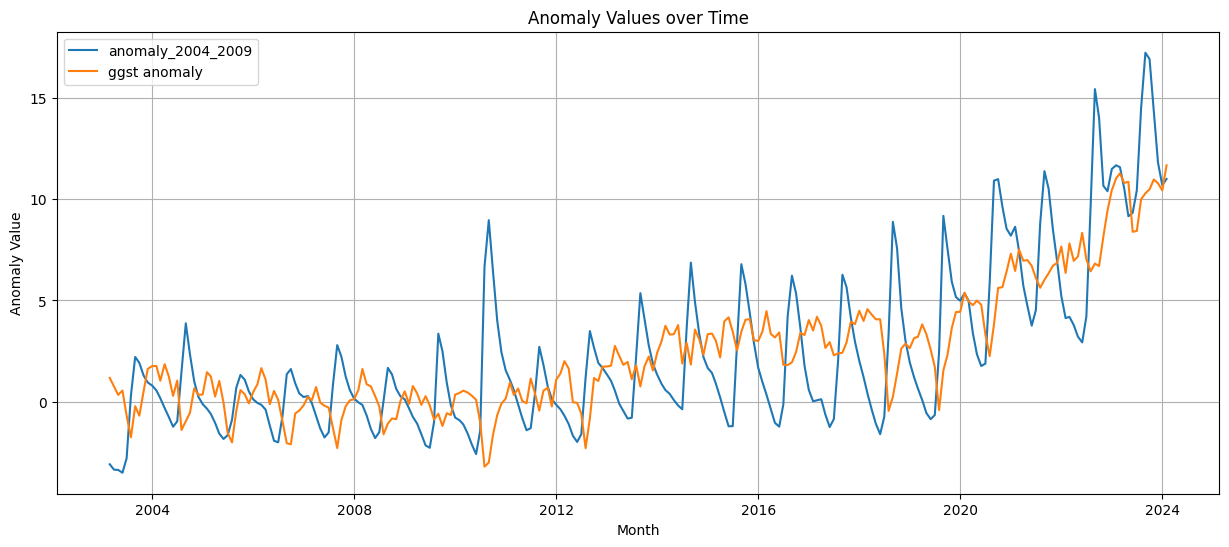

In [ ]:
# prompt: plot all of columns value of compare dataframe using matplotlib. use Month as x-axis,use only column anomaly_2004_2009 and ggst anomaly

import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'compare'
# Ensure 'Month' is in datetime format

# Convert 'Month' to datetime if it's not already
compare['Month'] = pd.to_datetime(compare['Month'])

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(compare['Month'], compare['anomaly_2004_2009'], label='anomaly_2004_2009')
plt.plot(compare['Month'], compare['ggst anomaly'], label='ggst anomaly')

plt.xlabel('Month')
plt.ylabel('Anomaly Value')
plt.title('Anomaly Values over Time')
plt.legend()
plt.grid(True)
plt.show()

Correlation between anomaly_2004_2009 and ggst anomaly: 0.6880019793522286
Mean Squared Error (MSE): 8.914635889476326
Root Mean Squared Error (RMSE): 2.985738751042416


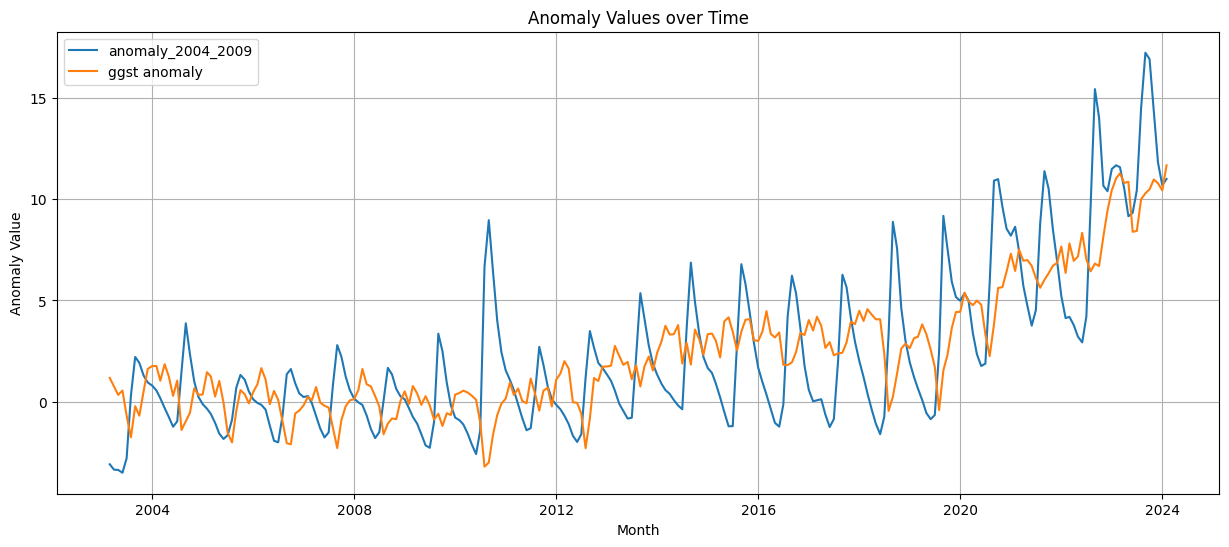

In [ ]:
# prompt: compare the KGE value between anomaly_2004_2009 and ggst anomaly

# Assuming your DataFrame is named 'compare'
# Ensure 'Month' is in datetime format

# Convert 'Month' to datetime if it's not already
compare['Month'] = pd.to_datetime(compare['Month'])

# Calculate the correlation between 'anomaly_2004_2009' and 'ggst anomaly'
correlation = compare['anomaly_2004_2009'].corr(compare['ggst anomaly'])

print(f"Correlation between anomaly_2004_2009 and ggst anomaly: {correlation}")

# You can also use other statistical measures to compare them, such as:

# Mean Squared Error (MSE)
mse = np.mean((compare['anomaly_2004_2009'] - compare['ggst anomaly'])**2)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(compare['Month'], compare['anomaly_2004_2009'], label='anomaly_2004_2009')
plt.plot(compare['Month'], compare['ggst anomaly'], label='ggst anomaly')

plt.xlabel('Month')
plt.ylabel('Anomaly Value')
plt.title('Anomaly Values over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# prompt: calculate KGE AND NSE

# Assuming your DataFrame is named 'compare' and you have 'anomaly_2004_2009' and 'ggst anomaly' columns.
# You can calculate KGE and NSE using the following code:

def kge(simulated, observed):
  """Calculates the Kling-Gupta Efficiency (KGE)."""
  correlation = np.corrcoef(simulated, observed)[0, 1]
  mean_ratio = np.mean(simulated) / np.mean(observed)
  variance_ratio = np.std(simulated) / np.std(observed)
  kge = 1 - np.sqrt((correlation - 1)**2 + (mean_ratio - 1)**2 + (variance_ratio - 1)**2)
  return kge

def nse(simulated, observed):
  """Calculates the Nash-Sutcliffe Efficiency (NSE)."""
  numerator = np.sum((observed - simulated)**2)
  denominator = np.sum((observed - np.mean(observed))**2)
  nse = 1 - (numerator / denominator)
  return nse


# Calculate KGE and NSE
kge_value = kge(compare['anomaly_2004_2009'], compare['ggst anomaly'])
nse_value = nse(compare['anomaly_2004_2009'], compare['ggst anomaly'])

print(f"Kling-Gupta Efficiency (KGE): {kge_value}")
print(f"Nash-Sutcliffe Efficiency (NSE): {nse_value}")

Kling-Gupta Efficiency (KGE): 0.5492365413323577
Nash-Sutcliffe Efficiency (NSE): 0.06778834604926176


In [ ]:
!pip install netCDF4 scipy xarray rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.1 MB/s eta 0:00:00


In [ ]:
# Install necessary libraries
!pip install rasterio xarray netCDF4 dask[complete]



# Import libraries
import xarray as xr
import rasterio
import glob
import os
import numpy as np
import pandas as pd
from dask import delayed, compute
from dask.diagnostics import ProgressBar
from tqdm import tqdm

def process_file(file):
    filename = os.path.basename(file)
    print(f"Processing file: {filename}")
    parts = filename.split('_')
    start_date_str = parts[-2]  # '2008-01-01'
    end_date_str = parts[-1].split('.')[0]  # '2008-12-31'

    try:
        start_date = pd.to_datetime(start_date_str, format='%Y-%m-%d')
        end_date = pd.to_datetime(end_date_str, format='%Y-%m-%d')
    except ValueError:
        print(f"Filename {filename} does not contain valid dates.")
        return []

    with rasterio.open(file) as src:
        num_bands = src.count
        dates = pd.date_range(start=start_date, end=end_date, periods=num_bands)

        data_arrays = []
        for i in range(num_bands):
            data = src.read(i + 1).astype(np.float32)
            height, width = src.height, src.width
            transform = src.transform
            crs = src.crs
            attrs = {'transform': transform, 'crs': crs.to_string()}

            da = xr.DataArray(
                data,
                dims=("y", "x"),
                coords={
                    "y": np.linspace(src.bounds.top, src.bounds.bottom, height),
                    "x": np.linspace(src.bounds.left, src.bounds.right, width),
                    "time": dates[i]
                },
                attrs=attrs
            )
            data_arrays.append(da)
    return data_arrays

def main():
    tiff_dir = "/content/drive/MyDrive/TWS_tavg"  # Update this path to your directory
    output_nc = "/content/drive/MyDrive/TWS_tavg/tws_tavg_output.nc"  # Update as needed

    file_list = sorted(glob.glob(os.path.join(tiff_dir, "*.tif")))
    print(f"Number of files found: {len(file_list)}")
    if not file_list:
        raise FileNotFoundError(f"No .tif files found in directory {tiff_dir}")

    data_arrays = []
    for file in tqdm(file_list, desc="Processing files"):
        das = process_file(file)
        if das:
            data_arrays.extend(das)
        else:
            print(f"Skipping file {file} due to processing error.")

    if not data_arrays:
        raise ValueError("No data was processed.")

    combined = xr.concat(data_arrays, dim="time")
    combined = combined.sortby('time')  # Ensure data is sorted by time

    ds = combined.to_dataset(name="TWS_tavg")
    ds.to_netcdf(output_nc)

    print(f"GeoTIFF files have been successfully converted to NetCDF: {output_nc}")

if __name__ == "__main__":
    main()


In [ ]:
# prompt: utilize colab gpu # Install necessary libraries
# !pip install rasterio xarray netCDF4 dask[complete]
# # Import libraries
# import xarray as xr
# import rasterio
# import glob
# import os
# import numpy as np
# import pandas as pd
# from dask import delayed, compute
# from dask.diagnostics import ProgressBar
# from tqdm import tqdm
# def process_file(file):
#     filename = os.path.basename(file)
#     print(f"Processing file: {filename}")
#     parts = filename.split('_')
#     start_date_str = parts[-2]  # '2008-01-01'
#     end_date_str = parts[-1].split('.')[0]  # '2008-12-31'
#     try:
#         start_date = pd.to_datetime(start_date_str, format='%Y-%m-%d')
#         end_date = pd.to_datetime(end_date_str, format='%Y-%m-%d')
#     except ValueError:
#         print(f"Filename {filename} does not contain valid dates.")
#         return []
#     with rasterio.open(file) as src:
#         num_bands = src.count
#         dates = pd.date_range(start=start_date, end=end_date, periods=num_bands)
#         data_arrays = []
#         f

# Check if GPU is available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
# Install necessary libraries
!pip install rasterio xarray netCDF4 dask[complete]

# Import libraries
import xarray as xr
import rasterio
import glob
import os
import numpy as np
import pandas as pd
from dask import delayed, compute
from dask.diagnostics import ProgressBar
from tqdm import tqdm

def process_file(file):
    filename = os.path.basename(file)
    print(f"Processing file: {filename}")
    parts = filename.split('_')
    start_date_str = parts[-2]  # '2008-01-01'
    end_date_str = parts[-1].split('.')[0]  # '2008-12-31'

    try:
        start_date = pd.to_datetime(start_date_str, format='%Y-%m-%d')
        end_date = pd.to_datetime(end_date_str, format='%Y-%m-%d')
    except ValueError:
        print(f"Filename {filename} does not contain valid dates.")
        return []

    with rasterio.open(file) as src:
        num_bands = src.count
        dates = pd.date_range(start=start_date, end=end_date, periods=num_bands)

        data_arrays = []
        for i in range(num_bands):
            data = src.read(i + 1).astype(np.float32)
            height, width = src.height, src.width
            transform = src.transform
            crs = src.crs
            attrs = {'transform': transform, 'crs': crs.to_string()}

            da = xr.DataArray(
                data,
                dims=("y", "x"),
                coords={
                    "y": np.linspace(src.bounds.top, src.bounds.bottom, height),
                    "x": np.linspace(src.bounds.left, src.bounds.right, width),
                    "time": dates[i]
                },
                attrs=attrs
            )
            data_arrays.append(da)
    return data_arrays

def main():
    tiff_dir = "/content/drive/MyDrive/TWS_tavg"  # Update this path to your directory
    output_nc = "/content/drive/MyDrive/TWS_tavg/tws_tavg_output.nc"  # Update as needed

    file_list = sorted(glob.glob(os.path.join(tiff_dir, "*.tif")))
    print(f"Number of files found: {len(file_list)}")
    if not file_list:
        raise FileNotFoundError(f"No .tif files found in directory {tiff_dir}")

    data_arrays = []
    for file in tqdm(file_list, desc="Processing files"):
        das = process_file(file)
        if das:
            data_arrays.extend(das)
        else:
            print(f"Skipping file {file} due to processing error.")

    if not data_arrays:
        raise ValueError("No data was processed.")

    combined = xr.concat(data_arrays, dim="time")
    combined = combined.sortby('time')  # Ensure data is sorted by time

    ds = combined.to_dataset(name="TWS_tavg")
    ds.to_netcdf(output_nc)

    print(f"GeoTIFF files have been successfully converted to NetCDF: {output_nc}")

if __name__ == "__main__":
    main()

Number of files found: 88


Processing files:   0%|          | 0/88 [00:00<?, ?it/s]

Processing file: CLSM_TWS_tavg_tile0_2003-01-01_2003-12-31.tif


Processing files:   1%|          | 1/88 [11:04<16:03:53, 664.75s/it]

Processing file: CLSM_TWS_tavg_tile0_2004-01-01_2004-12-31.tif


Processing files:   2%|▏         | 2/88 [24:10<17:34:50, 735.94s/it]

Processing file: CLSM_TWS_tavg_tile0_2005-01-01_2005-12-31.tif


Processing files:   3%|▎         | 3/88 [37:18<17:55:59, 759.52s/it]

Processing file: CLSM_TWS_tavg_tile0_2006-01-01_2006-12-31.tif


Processing files:   5%|▍         | 4/88 [50:29<18:00:49, 772.02s/it]

Processing file: CLSM_TWS_tavg_tile0_2007-01-01_2007-12-31.tif


Processing files:   6%|▌         | 5/88 [1:03:43<17:58:46, 779.84s/it]

Processing file: CLSM_TWS_tavg_tile0_2008-01-01_2008-12-31.tif


Processing files:   7%|▋         | 6/88 [1:17:01<17:54:22, 786.13s/it]

Processing file: CLSM_TWS_tavg_tile0_2009-01-01_2009-12-31.tif


Processing files:   8%|▊         | 7/88 [1:30:05<17:40:32, 785.59s/it]

Processing file: CLSM_TWS_tavg_tile0_2010-01-01_2010-12-31.tif


Processing files:   9%|▉         | 8/88 [1:43:39<17:39:33, 794.67s/it]

Processing file: CLSM_TWS_tavg_tile0_2011-01-01_2011-12-31.tif


Processing files:  10%|█         | 9/88 [1:56:42<17:21:15, 790.83s/it]

Processing file: CLSM_TWS_tavg_tile0_2012-01-01_2012-12-31.tif


Processing files:  11%|█▏        | 10/88 [2:09:54<17:08:45, 791.35s/it]

Processing file: CLSM_TWS_tavg_tile0_2013-01-01_2013-12-31.tif


Processing files:  12%|█▎        | 11/88 [2:23:30<17:05:09, 798.83s/it]

Processing file: CLSM_TWS_tavg_tile0_2014-01-01_2014-12-31.tif


Processing files:  14%|█▎        | 12/88 [2:37:11<17:00:27, 805.62s/it]

Processing file: CLSM_TWS_tavg_tile0_2015-01-01_2015-12-31.tif


Processing files:  15%|█▍        | 13/88 [2:51:45<17:12:50, 826.27s/it]

Processing file: CLSM_TWS_tavg_tile0_2016-01-01_2016-12-31.tif


In [ ]:
grace = ee.ImageCollection("NASA/GRACE/MASS_GRIDS_V03/MASCON").filter(ee.Filter.date('2003-02-01', '2024-05-31')).select('TWS_tavg')


In [ ]:
import geemap
import plotly.graph_objects as go
from datetime import datetime
import ee

# Load the ImageCollection
grace = ee.ImageCollection("NASA/GRACE/MASS_GRIDS_V03/MASCON")\
          .filter(ee.Filter.date('2003-02-01', '2024-09-02'))

anomaly = grace.select('lwe_thickness')

# Load your AOI shapefile as a FeatureCollection
aoi = ee.FeatureCollection('projects/ee-anomaitech/assets/niger_chad')

# Clip the ImageCollection to your AOI
clipped_ground_water = anomaly.map(lambda image: image.clip(aoi))

# Define the start and end dates for the years you want to filter
filtered_start_date = '2003-03-01'
filtered_end_date = '2024-05-31'

# Filter the ImageCollection to include only these years
filtered_ground_water = clipped_ground_water.filterDate(filtered_start_date, filtered_end_date)

# Define start and end dates as ee.Date
start_date = ee.Date(filtered_start_date)
end_date = ee.Date(filtered_end_date)

# Function to generate a list of monthly intervals between start and end dates
def get_month_list(start_date, end_date):
    difference = end_date.difference(start_date, 'month').round()
    months = ee.List.sequence(0, difference.subtract(1)).map(
        lambda m: start_date.advance(m, 'month')
    )
    return months

# Generate the list of months for the filtered years
months = get_month_list(start_date, end_date)

# Function to calculate the monthly mean ground water storage
def monthly_mean_image(date):
    start = ee.Date(date)
    end = start.advance(1, 'month')
    images_in_month = filtered_ground_water.filterDate(start, end)
    # Compute the mean image for the month
    monthly_mean = images_in_month.mean().set('month', start.format('YYYY-MM'))
    return monthly_mean

# Apply the function over the list of months to get monthly mean images
monthly_mean_images = ee.ImageCollection.fromImages(months.map(monthly_mean_image))

# Function to extract the mean ground water storage over the AOI
def extract_mean(image):
    # Check if 'lwe_thickness' band exists in the image
    band_names = image.bandNames()
    mean_dict = ee.Dictionary(ee.Algorithms.If(
        band_names.contains('lwe_thickness'),
        image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi.geometry(),
            scale=25000,
            maxPixels=1e13
        ),
        ee.Dictionary({'lwe_thickness': None})
    ))
    gws_tavg = mean_dict.get('lwe_thickness')
    return ee.Feature(None, {'month': image.get('month'), 'lwe_thickness': gws_tavg})

# Apply the extraction function over the monthly mean images
monthly_mean_values_fc = monthly_mean_images.map(extract_mean)

# Retrieve the months and mean values
months_list = monthly_mean_values_fc.aggregate_array('month').getInfo()
gws_tavg_list = monthly_mean_values_fc.aggregate_array('lwe_thickness').getInfo()

# Convert month strings to datetime objects and handle None values
gws_tavg_list = [float(value) if value is not None else None for value in gws_tavg_list]
months_datetime = [datetime.strptime(month, '%Y-%m') for month in months_list]

# Filter out None values for plotting
filtered_data = [(date, value) for date, value in zip(months_datetime, gws_tavg_list) if value is not None]
dates, values = zip(*filtered_data)

# Create the Plotly plot
fig = go.Figure(data=[go.Scatter(x=dates, y=values, mode='lines+markers')])
fig.update_layout(
    title='Monthly Mean Ground Water Storage ({} to {})'.format(filtered_start_date[:4], filtered_end_date[:4]),
    xaxis_title='Date',
    yaxis_title='Mean total water Storage (TGWS)'
)
fig.show()


In [ ]:
filtered_ground_water